## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split #, SubsetRandomSampler
import random
from tqdm import tqdm
# Display figures on jupyter notebook
%matplotlib inline

In [2]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [3]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [4]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

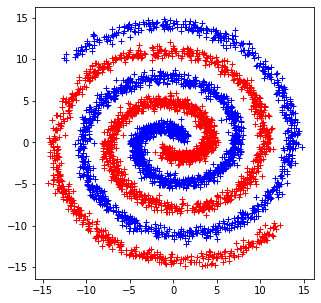

In [5]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [6]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just two layers. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [8]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 1)
     
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        h = torch.relu(self.l1(inputs))
        outputs = torch.sigmoid(self.l2(h))
        
        return outputs

In [9]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [10]:
# define a function for training
model.train()
import time
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    t=time.time()
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        ##print('Epoch [{}/{}], Loss: {:.4f}'
                     # .format(epoch+1, num_epochs, epoch_average_loss))
    elapsed = time.time()-t
    return train_error,elapsed

In [11]:
train_error, _ = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Text(0.5, 1.0, 'Visualization of convergence')

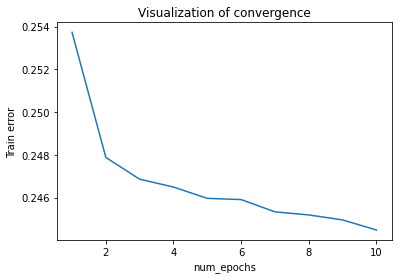

In [12]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [13]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [14]:
# predict labels for validation set
# model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
    #loss = criterion(y_val, y_pre.float())
    #print(loss.item())

In [15]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    return acc.item()
    # print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))

In [16]:
accuracy(y_val, y_pre)

0.5399999618530273

In [17]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

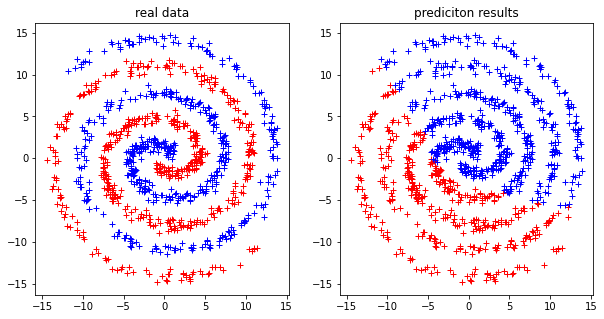

In [18]:
compare_pred(X_val, y_val, y_pre)

In [19]:
def preprocess(dataset, test_split=0.2, val_split=0.2):
    # Splitting the dataset
    test_size = int(len(dataset)*test_split)
    val_size = int(len(dataset)*val_split)
    train_size = len(dataset) - test_size - val_size
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set

In [20]:
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self, model, label_reshaper=None):
        super().__init__()
        self.model = model
        self.label_reshaper = label_reshaper

    def forward(self, x):
        output = self.model(x)
        return output

    def predict(self, dataset):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        predictions = self.forward(X)
        return predictions

    def evaluate(self, dataset, metrics):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        if self.label_reshaper:
                    y = self.label_reshaper(y)
        y_hat = self.forward(X)
        results = [metric[1](y, y_hat) for metric in metrics]
        return results

    def fit(self, train_set, val_set, loss_function, optimizer, metrics, num_epochs=20, batch_size=32, shuffle=True, verbose=5):

        # Defining the loaders
        train_loader = DataLoader(train_set, batch_size=batch_size)        
        
        loss_log = []
        val_loss_log = []
        metrics_logs = [[] for metric in metrics]
        val_metrics_logs = [[] for metric in metrics]

        # B-Training
        for epoch in range(num_epochs):
            # Training
            self.train()
            for x, y in train_loader:
                if self.label_reshaper:
                    y = self.label_reshaper(y)
                optimizer.zero_grad()
                y_hat = self.forward(x)
                loss = loss_function(y_hat, y.float())
                loss.backward()
                optimizer.step()
            
            # Logs
            self.eval()
            ## training set logs
            x, y = iter(DataLoader(train_set, batch_size=len(train_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y.float())
            loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                metrics_logs[idx].append(metric[1](y, y_hat)) 
                        
            ## validation set logs
            x, y = iter(DataLoader(val_set, batch_size=len(val_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y.float())
            val_loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                val_metrics_logs[idx].append(metric[1](y, y_hat))
            
            # Print logs
            if verbose and (epoch+1)%verbose == 0 or epoch==0:
                print("epoch: ", epoch+1)
                print("Training Loss: ", loss_log[epoch])
                print("Validation Loss: ", val_loss_log[epoch])
                for idx, metric in enumerate(metrics):
                    print(f"Training {metric[0]}: {metrics_logs[idx][epoch]}")
                    print(f"Validation {metric[0]}: {val_metrics_logs[idx][epoch]}")
        
        return loss_log, val_loss_log, metrics_logs, val_metrics_logs

In [21]:
def run_experiment(model, dataset, loss_function, optimizer, test_split=0.2, val_split=0.2, num_epochs=20, lr=0.01, batch_size=32, shuffle=True, verbose=5, initializer=None, label_reshaper=None):
    # Prepare dataset
    train_set, val_set, test_set = preprocess(dataset, test_split=test_split, val_split=val_split)

    # Instanciating the model
    model = Model(model, label_reshaper)

    # Applying weight initialization should the method be supplied
    if initializer is not None:
        model.apply(initializer)
        if verbose:
            print("Applied weight initialization")
    
    # Training the model
    loss_log, val_loss_log, metrics_logs, val_metrics_logs = model.fit(train_set, val_set, loss_function=loss_function, optimizer=optimizer, metrics=metrics, num_epochs=num_epochs, batch_size=batch_size, shuffle=shuffle, verbose=verbose)

    # Plotting results
    epoch_range = np.arange(num_epochs, dtype=int) + 1

    # Compute the number of rows for plotting the results given that we want 3 columns max per row
    n_metrics = len(metrics)
    n_columns = max(2, min(n_metrics, 3))
    n_rows = int(n_metrics / n_columns) + 1
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns, squeeze=False, figsize=(12,4))
    fig.tight_layout()

    walk = -1
    for ir, row in enumerate(ax):
        for ic, col in enumerate(row):
            if walk == -1: # loss function
                col.plot(epoch_range, loss_log, 'ro-', label='Training Loss')
                col.plot(epoch_range, val_loss_log, 'bx--', label='Validation Loss')
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel("Loss")
            elif walk < n_metrics:
                col.plot(epoch_range, val_metrics_logs[walk], 'ro-', label='Training '+metrics[walk][0])
                col.plot(epoch_range, val_metrics_logs[walk], 'bx--', label='Validation '+metrics[walk][0])
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel(metrics[walk][0])
            else:
                ax[ir, ic].axis('off')
                continue
            walk += 1
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

    # Evaluate model
    results = model.evaluate(test_set, metrics)

    # Print results
    for i, metric in enumerate(metrics):
        print(f"Test {metrics[i][0]}: ", "%.2f" % round(results[i], 2))


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

In [22]:
X, y = generate_data(6000)

In [23]:
# Global config
dataset = TensorDataset(X, y)
val_split=0.2
test_split=0.2
shuffle=True
initializer=None
metrics = [("Accuracy", accuracy)]

2-layer model

epoch:  1
Training Loss:  0.2850233018398285
Validation Loss:  0.2795785665512085
Training Accuracy: 0.5116666555404663
Validation Accuracy: 0.5091666579246521
epoch:  20
Training Loss:  0.24891574680805206
Validation Loss:  0.24783556163311005
Training Accuracy: 0.5449999570846558
Validation Accuracy: 0.53083336353302
epoch:  40
Training Loss:  0.24583253264427185
Validation Loss:  0.2469339817762375
Training Accuracy: 0.542222261428833
Validation Accuracy: 0.5199999809265137
epoch:  60
Training Loss:  0.24527384340763092
Validation Loss:  0.2473210096359253
Training Accuracy: 0.5416666269302368
Validation Accuracy: 0.5208333730697632
epoch:  80
Training Loss:  0.24505168199539185
Validation Loss:  0.24747179448604584
Training Accuracy: 0.5449999570846558
Validation Accuracy: 0.53166663646698
epoch:  100
Training Loss:  0.244886115193367
Validation Loss:  0.24744918942451477
Training Accuracy: 0.5491666793823242
Validation Accuracy: 0.5366666316986084


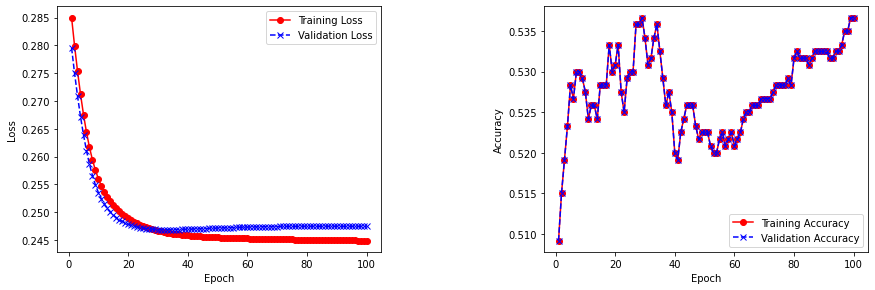

Test Accuracy:  0.55


In [24]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


3-layer model

epoch:  1
Training Loss:  0.24954456090927124
Validation Loss:  0.24990063905715942
Training Accuracy: 0.5069444179534912
Validation Accuracy: 0.4933333396911621
epoch:  20
Training Loss:  0.2475564181804657
Validation Loss:  0.24759724736213684
Training Accuracy: 0.5013889074325562
Validation Accuracy: 0.4908333420753479
epoch:  40
Training Loss:  0.24664707481861115
Validation Loss:  0.24678485095500946
Training Accuracy: 0.5269444584846497
Validation Accuracy: 0.5225000381469727
epoch:  60
Training Loss:  0.24618230760097504
Validation Loss:  0.24652844667434692
Training Accuracy: 0.5366666316986084
Validation Accuracy: 0.5216666460037231
epoch:  80
Training Loss:  0.24574391543865204
Validation Loss:  0.24651621282100677
Training Accuracy: 0.5302777886390686
Validation Accuracy: 0.5066666603088379
epoch:  100
Training Loss:  0.24547067284584045
Validation Loss:  0.2464766502380371
Training Accuracy: 0.528333306312561
Validation Accuracy: 0.5041666626930237


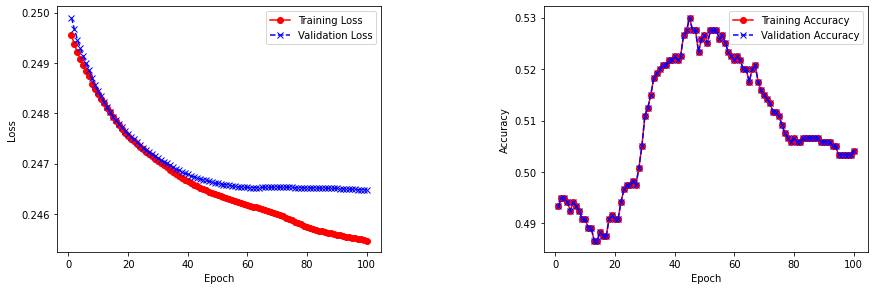

Test Accuracy:  0.53


In [25]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


7-layer model

epoch:  1
Training Loss:  0.2499324232339859
Validation Loss:  0.2499544322490692
Training Accuracy: 0.5036110877990723
Validation Accuracy: 0.5016666650772095
epoch:  20
Training Loss:  0.2498667687177658
Validation Loss:  0.24987757205963135
Training Accuracy: 0.5036110877990723
Validation Accuracy: 0.5016666650772095
epoch:  40
Training Loss:  0.24983395636081696
Validation Loss:  0.24983787536621094
Training Accuracy: 0.5036110877990723
Validation Accuracy: 0.5016666650772095
epoch:  60
Training Loss:  0.24981483817100525
Validation Loss:  0.24981631338596344
Training Accuracy: 0.5036110877990723
Validation Accuracy: 0.5016666650772095
epoch:  80
Training Loss:  0.2497977316379547
Validation Loss:  0.2497992217540741
Training Accuracy: 0.5325000286102295
Validation Accuracy: 0.5291666984558105
epoch:  100
Training Loss:  0.2497788518667221
Validation Loss:  0.24978183209896088
Training Accuracy: 0.49916666746139526
Validation Accuracy: 0.4925000071525574


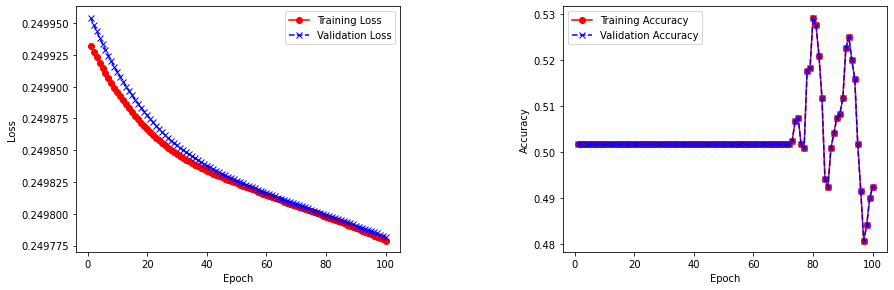

Test Accuracy:  0.52


In [26]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


With many layers, 7 here, we see that the model quickly overfits after around 30 epochs. The accuracy become stall after 40 epochs.

Let's take here the 2-layer model which performs best among the 3 previous experiments and try different activation functions (Sigmoid and Tanh)

Tanh activation

epoch:  1
Training Loss:  0.25422894954681396
Validation Loss:  0.2561071813106537
Training Accuracy: 0.5130555629730225
Validation Accuracy: 0.5058333277702332
epoch:  20
Training Loss:  0.24901138246059418
Validation Loss:  0.2499895691871643
Training Accuracy: 0.5172222256660461
Validation Accuracy: 0.5049999952316284
epoch:  40
Training Loss:  0.24763622879981995
Validation Loss:  0.248505100607872
Training Accuracy: 0.5361111164093018
Validation Accuracy: 0.5325000286102295
epoch:  60
Training Loss:  0.2468687891960144
Validation Loss:  0.2477695196866989
Training Accuracy: 0.5522222518920898
Validation Accuracy: 0.5491666793823242
epoch:  80
Training Loss:  0.2462858408689499
Validation Loss:  0.24723464250564575
Training Accuracy: 0.5525000095367432
Validation Accuracy: 0.5449999570846558
epoch:  100
Training Loss:  0.24576511979103088
Validation Loss:  0.24675120413303375
Training Accuracy: 0.5525000095367432
Validation Accuracy: 0.5516666769981384


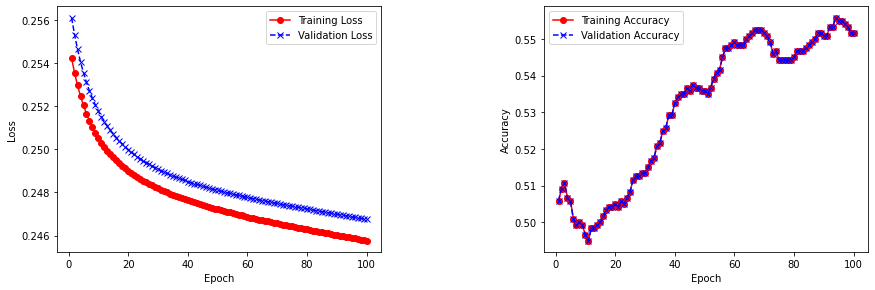

Test Accuracy:  0.55


In [27]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Sigmoid activation

epoch:  1
Training Loss:  0.2587330937385559
Validation Loss:  0.26010480523109436
Training Accuracy: 0.5083333253860474
Validation Accuracy: 0.5166666507720947
epoch:  20
Training Loss:  0.25456473231315613
Validation Loss:  0.2562550902366638
Training Accuracy: 0.5149999856948853
Validation Accuracy: 0.5183333158493042
epoch:  40
Training Loss:  0.25192368030548096
Validation Loss:  0.25378555059432983
Training Accuracy: 0.5186110734939575
Validation Accuracy: 0.512499988079071
epoch:  60
Training Loss:  0.25035545229911804
Validation Loss:  0.2523306906223297
Training Accuracy: 0.5258333683013916
Validation Accuracy: 0.5074999928474426
epoch:  80
Training Loss:  0.24940241873264313
Validation Loss:  0.25146767497062683
Training Accuracy: 0.5216666460037231
Validation Accuracy: 0.4975000023841858
epoch:  100
Training Loss:  0.24879910051822662
Validation Loss:  0.2509411871433258
Training Accuracy: 0.5288888812065125
Validation Accuracy: 0.503333330154419


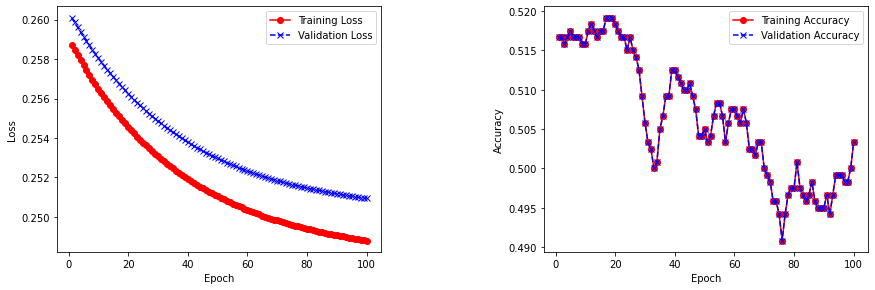

Test Accuracy:  0.53


In [28]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Tanh seems to perform better. This may be due to the fact that the activations are mapped in [-1, 1] range rather than [0,1] range for relu and sigmoid.

Different neurons

epoch:  1
Training Loss:  0.25861886143684387
Validation Loss:  0.25830668210983276
Training Accuracy: 0.5011111497879028
Validation Accuracy: 0.4891666769981384
epoch:  20
Training Loss:  0.24946461617946625
Validation Loss:  0.250815749168396
Training Accuracy: 0.5158333778381348
Validation Accuracy: 0.5041666626930237
epoch:  40
Training Loss:  0.24886231124401093
Validation Loss:  0.2504705786705017
Training Accuracy: 0.53083336353302
Validation Accuracy: 0.5216666460037231
epoch:  60
Training Loss:  0.24833054840564728
Validation Loss:  0.25003936886787415
Training Accuracy: 0.5338888764381409
Validation Accuracy: 0.5208333730697632
epoch:  80
Training Loss:  0.2478952705860138
Validation Loss:  0.24966444075107574
Training Accuracy: 0.5372222661972046
Validation Accuracy: 0.5258333683013916
epoch:  100
Training Loss:  0.24752932786941528
Validation Loss:  0.24933379888534546
Training Accuracy: 0.5327777862548828
Validation Accuracy: 0.5225000381469727


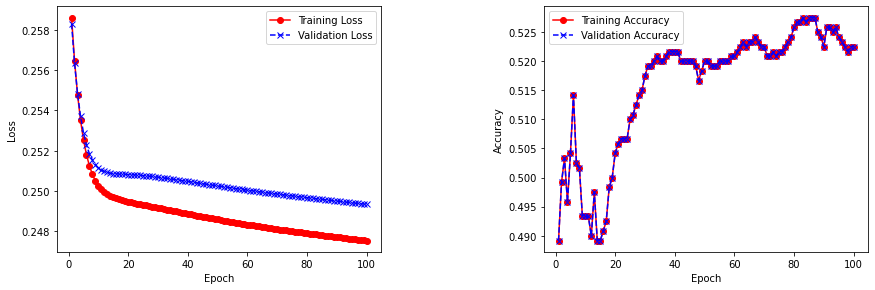

Test Accuracy:  0.54


In [29]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


3-layer model with tanh

epoch:  1
Training Loss:  0.25084438920021057
Validation Loss:  0.25016143918037415
Training Accuracy: 0.5258333683013916
Validation Accuracy: 0.5208333730697632
epoch:  20
Training Loss:  0.24932071566581726
Validation Loss:  0.2491147816181183
Training Accuracy: 0.5288888812065125
Validation Accuracy: 0.5325000286102295
epoch:  40
Training Loss:  0.2487064003944397
Validation Loss:  0.248908132314682
Training Accuracy: 0.5372222661972046
Validation Accuracy: 0.53166663646698
epoch:  60
Training Loss:  0.24830803275108337
Validation Loss:  0.24883407354354858
Training Accuracy: 0.5366666316986084
Validation Accuracy: 0.5291666984558105
epoch:  80
Training Loss:  0.2479788213968277
Validation Loss:  0.24877196550369263
Training Accuracy: 0.5383332967758179
Validation Accuracy: 0.53083336353302
epoch:  100
Training Loss:  0.24768446385860443
Validation Loss:  0.24870754778385162
Training Accuracy: 0.5363888740539551
Validation Accuracy: 0.5275000333786011


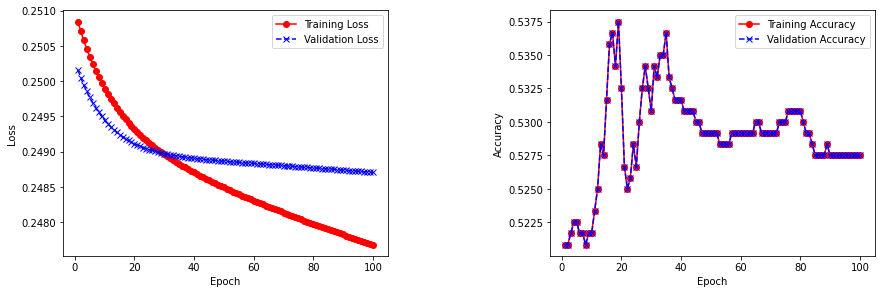

Test Accuracy:  0.55


In [30]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercise 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Batch size

Batch size = 1

epoch:  1
Training Loss:  0.24721954762935638
Validation Loss:  0.23957090079784393
Training Accuracy: 0.534166693687439
Validation Accuracy: 0.5833333730697632


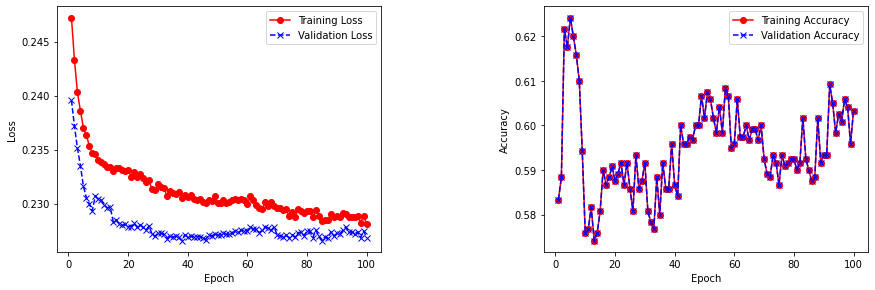

Test Accuracy:  0.62


In [31]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 1
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


batchzise = 10

epoch:  1
Training Loss:  0.25121545791625977
Validation Loss:  0.25337740778923035
Training Accuracy: 0.5213888883590698
Validation Accuracy: 0.5074999928474426
epoch:  20
Training Loss:  0.23870566487312317
Validation Loss:  0.24015718698501587
Training Accuracy: 0.5877777338027954
Validation Accuracy: 0.5850000381469727
epoch:  40
Training Loss:  0.22981223464012146
Validation Loss:  0.23200614750385284
Training Accuracy: 0.5763888955116272
Validation Accuracy: 0.5733333230018616
epoch:  60
Training Loss:  0.22321678698062897
Validation Loss:  0.22556854784488678
Training Accuracy: 0.5874999761581421
Validation Accuracy: 0.5850000381469727
epoch:  80
Training Loss:  0.21908459067344666
Validation Loss:  0.22168320417404175
Training Accuracy: 0.5902777910232544
Validation Accuracy: 0.59416663646698
epoch:  100
Training Loss:  0.2159656137228012
Validation Loss:  0.21852515637874603
Training Accuracy: 0.6038888692855835
Validation Accuracy: 0.6108333468437195


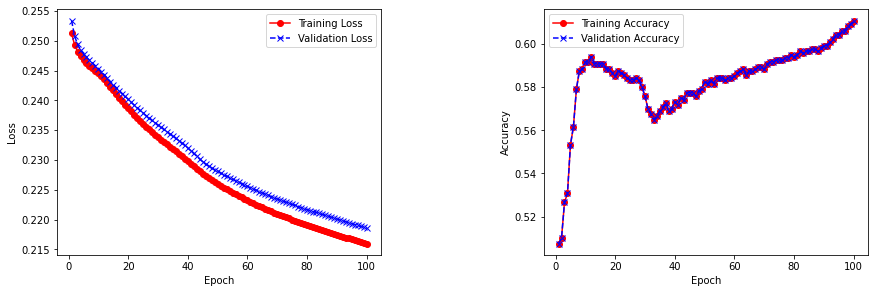

Test Accuracy:  0.58


In [32]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 10
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=20


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Batch size 50

epoch:  1
Training Loss:  0.25108328461647034
Validation Loss:  0.2537417709827423
Training Accuracy: 0.4630555510520935
Validation Accuracy: 0.44749999046325684


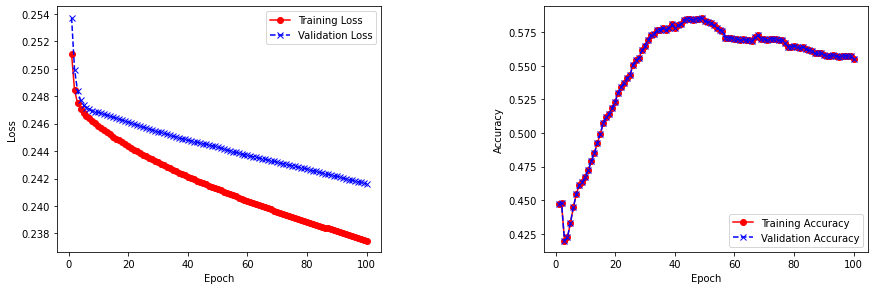

Test Accuracy:  0.55


In [33]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 50
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=0


run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Optimizer

RMSprop

epoch:  1
Training Loss:  0.25604942440986633
Validation Loss:  0.254819393157959
Training Accuracy: 0.5344444513320923
Validation Accuracy: 0.5391666889190674


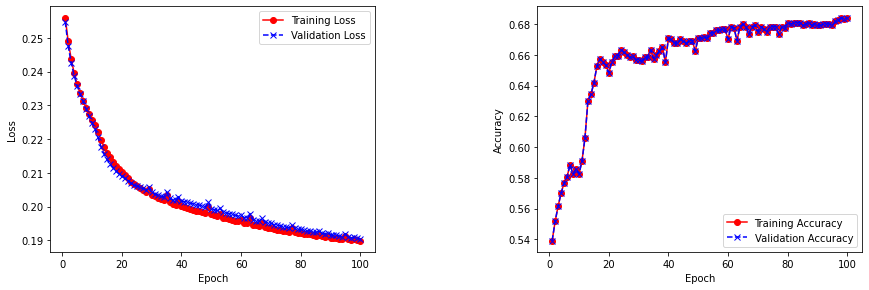

Test Accuracy:  0.67


In [34]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


RMSprop with lr = 0.1

epoch:  1
Training Loss:  0.459642618894577
Validation Loss:  0.4411579966545105
Training Accuracy: 0.5299999713897705
Validation Accuracy: 0.550000011920929


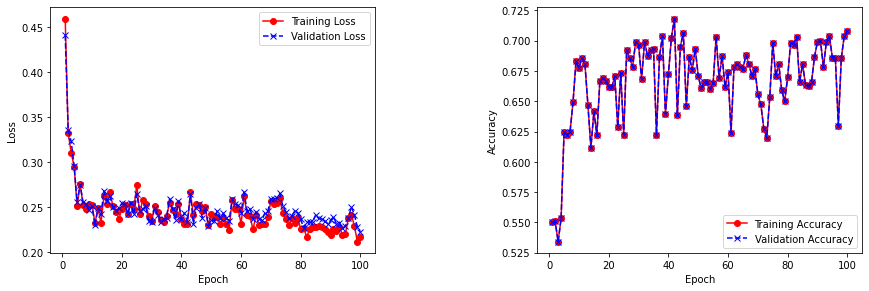

Test Accuracy:  0.68


In [35]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.1
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


This plot suggests that lr=0.1 is too high.

epoch:  1
Training Loss:  0.24612335860729218
Validation Loss:  0.24416685104370117
Training Accuracy: 0.5550000071525574
Validation Accuracy: 0.5608333349227905


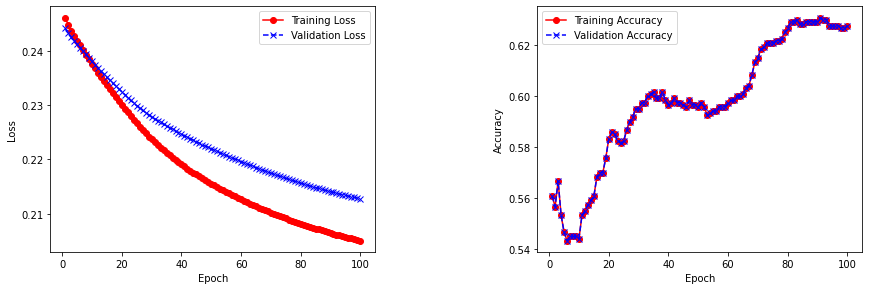

Test Accuracy:  0.63


In [36]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Adam optimizer lr =0.01

epoch:  1
Training Loss:  0.24352328479290009
Validation Loss:  0.24748677015304565
Training Accuracy: 0.5744444131851196
Validation Accuracy: 0.5375000238418579


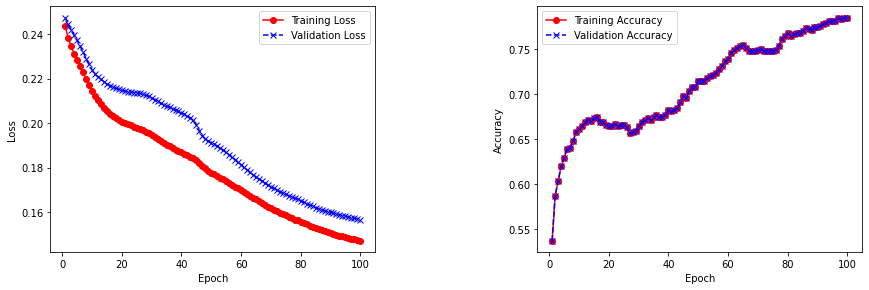

Test Accuracy:  0.76


In [37]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Adam optimizer lr =0.01 and 200 epochs

epoch:  1
Training Loss:  0.24284158647060394
Validation Loss:  0.24347248673439026
Training Accuracy: 0.5649999976158142
Validation Accuracy: 0.5616666674613953


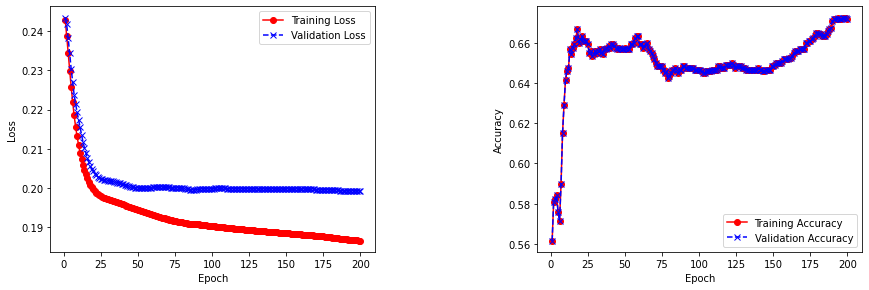

Test Accuracy:  0.69


In [38]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 200
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Adam with lr = 0.1 and 150 epochs

epoch:  1
Training Loss:  0.2651234567165375
Validation Loss:  0.2658497989177704
Training Accuracy: 0.5330555438995361
Validation Accuracy: 0.5199999809265137


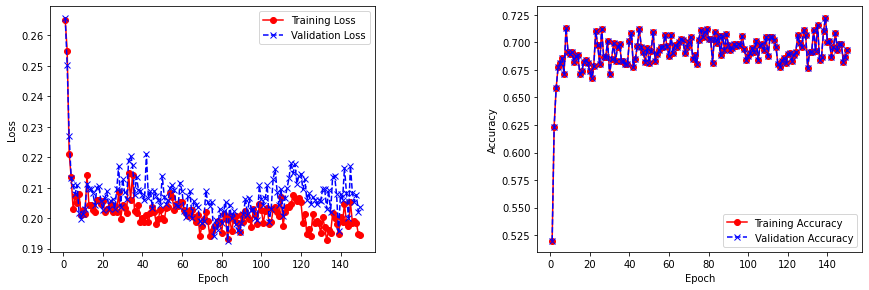

Test Accuracy:  0.71


In [39]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid())

def mse_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 150
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=mse_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


Again lr =0.1 is too high. 0.01 seems to work fine.
as a mini conclusion, Adam here performs better than the other optimizers.

### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

epoch:  1
Training Loss:  0.6790755987167358
Validation Loss:  0.6845226883888245
Training Accuracy: 0.503333330154419
Validation Accuracy: 0.49666666984558105


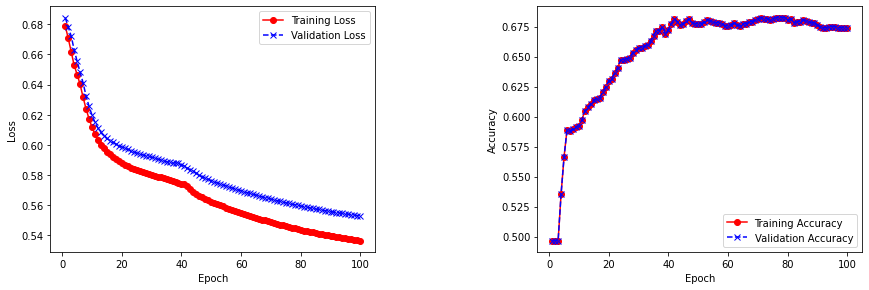

Test Accuracy:  0.70


In [40]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 1))

def bcewl_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 100
batch_size = 64
loss_function = nn.BCEWithLogitsLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=bcewl_reshaper
verbose=None

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

epoch:  1
Training Loss:  0.6820536255836487
Validation Loss:  0.6815749406814575
Training Accuracy: 0.5363888740539551
Validation Accuracy: 0.5191667079925537
epoch:  5
Training Loss:  0.254875123500824
Validation Loss:  0.23295654356479645
Training Accuracy: 0.8761110901832581
Validation Accuracy: 0.8833333253860474
epoch:  10
Training Loss:  0.24845220148563385
Validation Loss:  0.21902495622634888
Training Accuracy: 0.8774999976158142
Validation Accuracy: 0.8933333158493042
epoch:  15
Training Loss:  0.07899279147386551
Validation Loss:  0.1050209030508995
Training Accuracy: 0.9769444465637207
Validation Accuracy: 0.9674999713897705
epoch:  20
Training Loss:  0.011241791769862175
Validation Loss:  0.040866669267416
Training Accuracy: 0.996666669845581
Validation Accuracy: 0.9925000071525574
epoch:  25
Training Loss:  0.006665667053312063
Validation Loss:  0.011578175239264965
Training Accuracy: 0.9980555772781372
Validation Accuracy: 0.9975000023841858


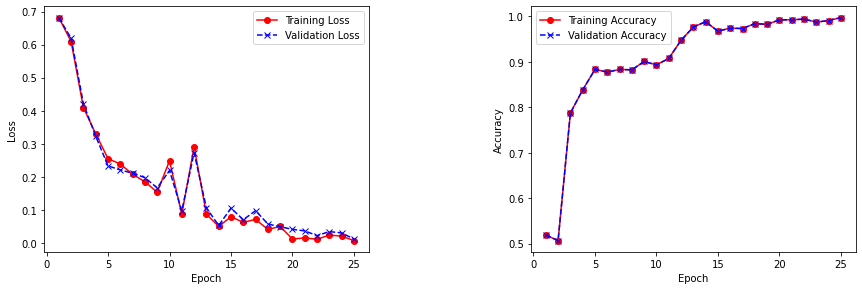

Test Accuracy:  1.00


In [41]:
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1))

def bcewl_reshaper(y):
    return y.reshape(-1, 1)

num_epochs = 25
batch_size = 50
loss_function = nn.BCEWithLogitsLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=bcewl_reshaper
verbose=5

run_experiment(model, dataset, loss_function, optimizer, test_split=val_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)

       